## Projeto Precificação de Carros
O Grupo Zello de concessionárias tem mais de 300 lojas espalhadas pelo Brasil e mundo, suas lojas vendem carros de todas as marcas e modelos, carros novos e usados. Após um trimestre com resultados abaixo da meta, o gestor da rede solicitou uma análise completa da empresa para entender a causa fundamental do acontecido, ao final deste trabalho os especialistas de negócio criaram uma hipótese de que carros parecidos estão sendo vendidos com valores muito diferentesem o código em funções.

### Desafio
Você é o mais novo cientista de dados das Concessionárias Zello e dado o problema apresentado entende que o melhor a fazer é padronizar o processo de precificação dos carros utilizando um modelo de machine learning. Esse modelo auxiliará o time de vendas a entender quanto cada carro vale antes mesmo dele ser vendido e pode ajudar na redução da dispersão do preço de venda entre carros parecidos.
Você deverá montar um modelo de machine learning que, utilizando as características de cada carro, prevê seu valor de venda com o menor erro possível.

### Métrica de avaliação

O seu trabalho será avaliado utilizando duas métricas:

* Métrica técnica: RMSE e R²
* Métrica de negócio: desvio padrão dos preços de venda (com a utilização do modelo e sem a utilização do modelo)

### Análises e Entregáveis

Ao final do trabalho você deve ter:

* Um modelo de regressão capaz de prever o valor de um novo carro (dadas suas características)
* Confiança e dados para responder as seguintes perguntas:
    * Qual a dispersão entre os valores de venda de carros parecidos?
    * Se estivéssemos utilizando o modelo em 1000 vendas escolhidas aleatoriamente teríamos ganhado mais ou menos?


### Dicas
1. Treinem e avaliem mais de um modelo de regressão (LinearRegression, DecisionTreeRegressor, RandomForestRegressor, KNeighborsRegressor)
2. Pesquisem sobre tratamento de variáveis categóricas e não esqueçam o seu tratamento (utilizando OneHotEncoding ou outra técnica que acharem interessante)
3. Criem gráficos para sustentar suas análises
4. Organizem o código em funções.

# Projeto

### Importações

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial import distance

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

### Dados

In [2]:
## importando dados

df = pd.read_csv('data/car_price_prediction.csv')
df.columns = [x.lower().replace('.','').replace(' ','_') for x in df.columns]
df.head()

,id,price,levy,manufacturer,model,prod_year,category,leather_interior,fuel_type,engine_volume,mileage,cylinders,gear_box_type,drive_wheels,doors,wheel,color,airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [3]:
## inspecionando os valores nulos

df.isna().sum()

id                  0
price               0
levy                0
manufacturer        0
model               0
prod_year           0
category            0
leather_interior    0
fuel_type           0
engine_volume       0
mileage             0
cylinders           0
gear_box_type       0
drive_wheels        0
doors               0
wheel               0
color               0
airbags             0
dtype: int64

### Inspeção de dados

In [4]:
df.sample(5)

,id,price,levy,manufacturer,model,prod_year,category,leather_interior,fuel_type,engine_volume,mileage,cylinders,gear_box_type,drive_wheels,doors,wheel,color,airbags
12265,45732633,15530,891,HYUNDAI,Sonata,2016,Sedan,Yes,LPG,2,246040 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
1382,45802780,13962,707,HYUNDAI,Santa FE,2011,Jeep,Yes,Diesel,2,240250 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
6378,45785504,45473,1091,TOYOTA,RAV 4,2016,Jeep,No,Petrol,2.5,60800 km,4.0,Automatic,4x4,04-May,Left wheel,Black,12
1613,45767605,37633,-,LINCOLN,MKZ,2013,Sedan,Yes,Hybrid,2,82817 km,4.0,Variator,Front,04-May,Left wheel,White,12
17291,45772511,627,1750,TOYOTA,Highlander,2008,Sedan,Yes,Hybrid,3.3,277405 km,6.0,Automatic,4x4,04-May,Left wheel,Grey,12


In [5]:
df.describe()

,id,price,prod_year,cylinders,airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,2010.912824,4.582991,6.582627
std,9.365914e+05,1.905813e+05,5.668673,1.199933,4.320168
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


In [6]:
df.describe(percentiles=[0.25,0.5,0.75,0.99],include='all')

,id,price,levy,manufacturer,model,prod_year,category,leather_interior,fuel_type,engine_volume,mileage,cylinders,gear_box_type,drive_wheels,doors,wheel,color,airbags
count,1.923700e+04,1.923700e+04,19237,19237,19237,19237.000000,19237,19237,19237,19237,19237,19237.000000,19237,19237,19237,19237,19237,19237.000000
unique,NaN,NaN,559,65,1590,NaN,11,2,7,107,7687,NaN,4,3,3,2,16,NaN
top,NaN,NaN,-,HYUNDAI,Prius,NaN,Sedan,Yes,Petrol,2,0 km,NaN,Automatic,Front,04-May,Left wheel,Black,NaN
freq,NaN,NaN,5819,3769,1083,NaN,8736,13954,10150,3916,721,NaN,13514,12874,18332,17753,5033,NaN
mean,4.557654e+07,1.855593e+04,NaN,NaN,NaN,2010.912824,NaN,NaN,NaN,NaN,NaN,4.582991,NaN,NaN,NaN,NaN,NaN,6.582627
std,9.365914e+05,1.905813e+05,NaN,NaN,NaN,5.668673,NaN,NaN,NaN,NaN,NaN,1.199933,NaN,NaN,NaN,NaN,NaN,4.320168
min,2.074688e+07,1.000000e+00,NaN,NaN,NaN,1939.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000
25%,4.569837e+07,5.331000e+03,NaN,NaN,NaN,2009.000000,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,4.000000
50%,4.577231e+07,1.317200e+04,NaN,NaN,NaN,2012.000000,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,6.000000
75%,4.580204e+07,2.207500e+04,NaN,NaN,NaN,2015.000000,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,12.000000


<Axes: xlabel='prod_year', ylabel='price'>

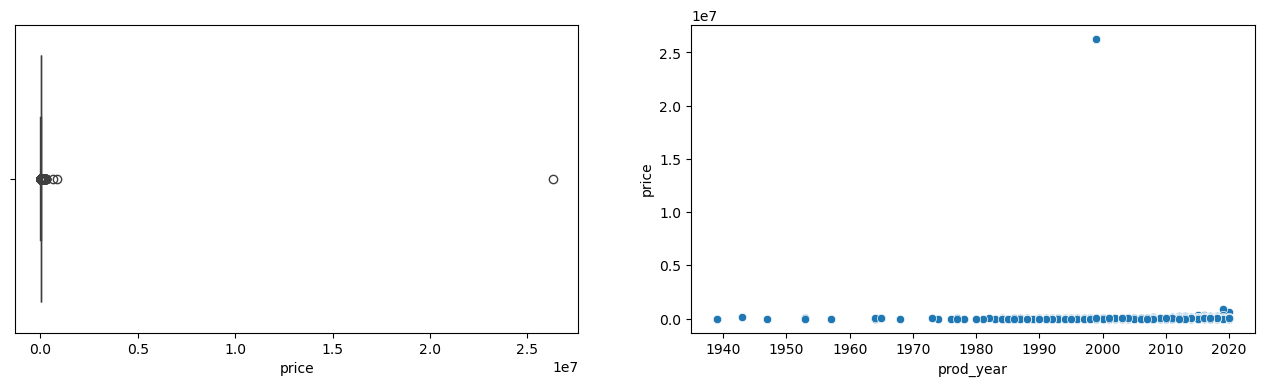

In [7]:
f, ax = plt.subplots(1,2, figsize=(16,4))

sns.boxplot(x=df.price, ax=ax[0])
sns.scatterplot(df, x='prod_year', y='price')

<Axes: xlabel='prod_year', ylabel='price'>

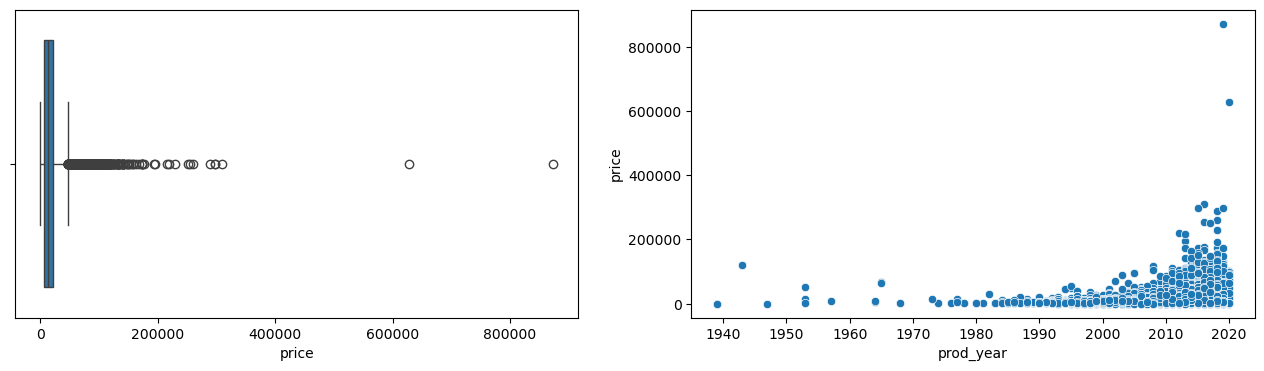

In [8]:
data_plot = df.drop(df.price.argmax())

f, ax = plt.subplots(1,2, figsize=(16,4))

sns.boxplot(x=data_plot.price, ax=ax[0])
sns.scatterplot(data_plot, x='prod_year', y='price')

### Tratamento e limpeza de dados

- [X] Remover "km" da coluna <code>mileage</code>
- [X] Dropar a coluna <code>levy</code>
- [X] Trocar as colunas <code>id, manufacturer, model, category, leather_interior, fuel_type, engine_volume, gear_box_type, drive_wheels, wheel, color, doors</code> para tipo categoria.
- [X] Criar a coluna <code>sku</code> com informações sobre marca, modelo e volume do motor
- [X] Remover outliers da coluna <code>price</code> utilizando 400k de valor de referência.
- [X] Dropar a coluna <code>levy</code>

In [9]:
df_clean = df.copy()

In [10]:
## removendo "km" da coluna mileage

df_clean['mileage'] = df_clean.mileage.str.strip(' km').astype(int)

df_clean.mileage.head()

0    186005
1    192000
2    200000
3    168966
4     91901
Name: mileage, dtype: int64

In [11]:
## trocando as colunas de tipo

cat_columns = ['id', 'category', 'leather_interior', 
               'fuel_type', 'engine_volume', 'gear_box_type', 'drive_wheels', 'wheel', 
               'color','doors']

for column in cat_columns:
    df_clean[column] = df_clean[column].astype('category')

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   id                19237 non-null  category
 1   price             19237 non-null  int64   
 2   levy              19237 non-null  object  
 3   manufacturer      19237 non-null  object  
 4   model             19237 non-null  object  
 5   prod_year         19237 non-null  int64   
 6   category          19237 non-null  category
 7   leather_interior  19237 non-null  category
 8   fuel_type         19237 non-null  category
 9   engine_volume     19237 non-null  category
 10  mileage           19237 non-null  int64   
 11  cylinders         19237 non-null  float64 
 12  gear_box_type     19237 non-null  category
 13  drive_wheels      19237 non-null  category
 14  doors             19237 non-null  category
 15  wheel             19237 non-null  category
 16  color             1923

<Axes: xlabel='prod_year', ylabel='price'>

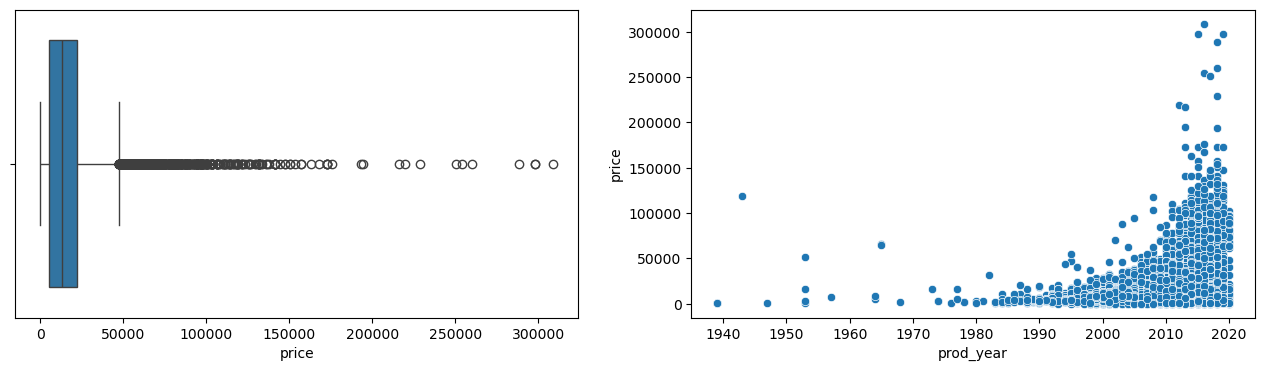

In [12]:
## removendo outlier da coluna price

df_clean = df_clean[df_clean.price < 400000]

f, ax = plt.subplots(1,2, figsize=(16,4))

sns.boxplot(x=df_clean.price, ax=ax[0])
sns.scatterplot(df_clean, x='prod_year', y='price')

In [13]:
## dropando a coluna levy

df_clean.drop(['levy'], axis=1, inplace=True)

In [14]:
df_clean['is_turbo'] = df_clean.engine_volume.str.split(' ').apply(lambda x: 1 if len(x) == 2 else 0).astype('category')
df_clean['engine_volume'] = df_clean.engine_volume.str.split(' ').apply(lambda x: x[0]).astype('category')
df_clean['sku'] = df_clean.manufacturer.str.lower()+'_'+df_clean.model.str.replace(' ','_').str.lower()+'_'+df_clean.engine_volume.astype('str')
df_clean['sku'] = df_clean['sku'].astype('category')
df_clean.set_index('id',inplace=True)

### Análise da métrica de negócio

- [X] Definição de similaridade
- [X] Cálculo de dispersão

Devido a grande quantidade de categorias e modelos utilizaremos a coluna SKU para fazer a similaridade e a dispersão de preço será calculada utilizando o desvio padrão. Também removeremos do cálculo e da nossa análise qualquer carro que tenha sido vendido menos de 100 vezes.

In [15]:
vendas = df_clean.sku.value_counts()
carros_acima_100_vendas = vendas[vendas > 100].index

In [16]:
disp_carros_acima_100_vendas = (
    df_clean[['sku','price']][df_clean.sku.isin(carros_acima_100_vendas)]
    .groupby('sku')
    .std()
    .sort_values('price', ascending=False)
    .T
)

disp_carros_acima_100_vendas

/tmp/ipykernel_1585/3058527431.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sku')


sku,lexus_gx_460_4.6,lexus_rx_450_3.5,toyota_rav_4_2.5,hyundai_santa_fe_2,toyota_camry_2.5,hyundai_sonata_2,mercedes-benz_e_350_3.5,hyundai_elantra_2,honda_fit_1.5,hyundai_h1_2.5,...,volvo_s80_2.4,volvo_v50_1.6,volvo_xc90_2.5,volvo_xc90_2.5turbo_2.5,volvo_xc90_3.2,volvo_xc90_3.2_awd_3.2,zaz_969_968m_0.8,zaz_969_luaz_0.9,სხვა_gonow_2.3,სხვა_iveco_dayly_2.3
price,28631.007516,18358.080257,18332.378616,15871.97005,13387.479121,13034.674183,12667.547416,12604.186885,12411.903665,11956.90723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preparação de dados

In [17]:
carros_alvo = (
    df_clean[df_clean.sku.isin(carros_acima_100_vendas)]
    .drop(['manufacturer','model','category','engine_volume'],axis=1)
)

carros_alvo.head()

,price,prod_year,leather_interior,fuel_type,mileage,cylinders,gear_box_type,drive_wheels,doors,wheel,color,airbags,is_turbo,sku
id,,,,,,,,,,,,,,
45654403,13328,2010,Yes,Hybrid,186005,6.0,Automatic,4x4,04-May,Left wheel,Silver,12,0,lexus_rx_450_3.5
45774419,8467,2006,No,Petrol,200000,4.0,Variator,Front,04-May,Right-hand drive,Black,2,0,honda_fit_1.3
45809263,11726,2014,Yes,Petrol,91901,4.0,Automatic,Front,04-May,Left wheel,Silver,4,0,honda_fit_1.3
45802912,39493,2016,Yes,Diesel,160931,4.0,Automatic,Front,04-May,Left wheel,White,4,0,hyundai_santa_fe_2
45656768,1803,2010,Yes,Hybrid,258909,4.0,Automatic,Front,04-May,Left wheel,White,12,0,toyota_prius_1.8


In [18]:
x, y = carros_alvo.drop(['price'],axis=1), carros_alvo.price

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [19]:
cat_cols = x.select_dtypes(include='category').columns
num_cols = x.select_dtypes(exclude='category').columns

In [41]:
col_transf = ColumnTransformer(
    [('ohe',OneHotEncoder(handle_unknown='ignore'),cat_cols)],
    remainder='passthrough'
)

col_transf

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['leather_interior', 'fuel_type', 'gear_box_type', 'drive_wheels',
       'doors', 'wheel', 'color', 'is_turbo', 'sku'],
      dtype='object'))])

### Criar modelo baseline

- [X] Definir e treinar modelo baseline
- [X] Avaliar métricas técnicas para baseline

In [42]:
pipe = make_pipeline(col_transf,DummyRegressor())
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['leather_interior', 'fuel_type', 'gear_box_type', 'drive_wheels',
       'doors', 'wheel', 'color', 'is_turbo', 'sku'],
      dtype='object'))])),
                ('dummyregressor', DummyRegressor())])

In [43]:
pipe.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['leather_interior', 'fuel_type', 'gear_box_type', 'drive_wheels',
       'doors', 'wheel', 'color', 'is_turbo', 'sku'],
      dtype='object'))])),
                ('dummyregressor', DummyRegressor())])

In [44]:
r2_score(y_test, pipe.predict(x_test))

-1.0004616834091706e-05

In [45]:
mean_squared_error(y_test, pipe.predict(x_test))**0.5

15182.830469232029

### Criando e avaliando modelos

In [46]:
models = [DecisionTreeRegressor(random_state=42), RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)]

In [47]:
for model in models:
    print(type(model).__name__)
    model_pipe = make_pipeline(
        col_transf,
        model
    )
    
    model_pipe.fit(x_train, y_train)
    
    print("R2", r2_score(y_test, model_pipe.predict(x_test)))
    print("RMSE",mean_squared_error(y_test, model_pipe.predict(x_test))**0.5)
    print()

DecisionTreeRegressor
R2 0.6935921186879084
RMSE 8404.280447581112

RandomForestRegressor
R2 0.7800326037129209
RMSE 7120.815401665806



### Procurando os melhores parâmetros

In [48]:
model = RandomForestRegressor(random_state=42)
model_pipe = make_pipeline(
    col_transf,
    model
)

model_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['leather_interior', 'fuel_type', 'gear_box_type', 'drive_wheels',
       'doors', 'wheel', 'color', 'is_turbo', 'sku'],
      dtype='object'))])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [49]:
params = {'randomforestregressor__n_estimators':[200,300,400,500],
         'randomforestregressor__min_samples_leaf': [10,20,30,40],
         'randomforestregressor__max_features':[5,10,15,None]}

In [54]:
search = GridSearchCV(model_pipe, param_grid=params, scoring=['neg_root_mean_squared_error','r2'], cv=5, return_train_score=True, verbose=3, refit=False)
search.fit(x_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END randomforestregressor__max_features=5, randomforestregressor__min_samples_leaf=10, randomforestregressor__n_estimators=200; neg_root_mean_squared_error: (train=-9665.977, test=-9863.473) r2: (train=0.578, test=0.572) total time=   0.6s
[CV 2/5] END randomforestregressor__max_features=5, randomforestregressor__min_samples_leaf=10, randomforestregressor__n_estimators=200; neg_root_mean_squared_error: (train=-9465.860, test=-9909.899) r2: (train=0.599, test=0.552) total time=   0.6s
[CV 3/5] END randomforestregressor__max_features=5, randomforestregressor__min_samples_leaf=10, randomforestregressor__n_estimators=200; neg_root_mean_squared_error: (train=-9507.133, test=-9781.203) r2: (train=0.594, test=0.571) total time=   0.7s
[CV 4/5] END randomforestregressor__max_features=5, randomforestregressor__min_samples_leaf=10, randomforestregressor__n_estimators=200; neg_root_mean_squared_error: (train=-9601.411, test=-9

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['leather_interior', 'fuel_type', 'gear_box_type', 'drive_wheels',
       'doors', 'wheel', 'color', 'is_turbo', 'sku'],
      dtype='object'))])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'randomforestregressor__max_features': [5, 10, 15,
                                                                 None],
                         'randomforestregressor__min_samples_leaf': [10, 20, 30,
                                                                     40],
                         'randomforestregressor__n_estimators': [200, 300, 400,
                                                                 500]},
             refit=False, return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=3)

In [58]:
search_df = pd.DataFrame(search.cv_results_)
search_df.sort_values('mean_test_r2', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__max_features,param_randomforestregressor__min_samples_leaf,param_randomforestregressor__n_estimators,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,...,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2
51,18.968660,0.687460,0.071751,0.001174,None,10,500,"{'randomforestregressor__max_features': None, ...",-7666.443169,-8044.297823,...,0.728381,0.024124,1,0.793445,0.798724,0.799497,0.789835,0.796621,0.795624,0.003574
50,14.755688,1.000400,0.089307,0.064854,None,10,400,"{'randomforestregressor__max_features': None, ...",-7663.045050,-8057.912223,...,0.728267,0.024089,2,0.793473,0.798151,0.799358,0.790171,0.796863,0.795603,0.003353
49,12.172951,0.938541,0.053534,0.013308,None,10,300,"{'randomforestregressor__max_features': None, ...",-7669.428342,-8048.183254,...,0.728086,0.023891,3,0.793218,0.797714,0.799055,0.789818,0.796557,0.795272,0.003344
48,8.092860,0.874953,0.036874,0.005820,None,10,200,"{'randomforestregressor__max_features': None, ...",-7664.123010,-8047.176199,...,0.727905,0.023493,4,0.793510,0.797757,0.799390,0.789458,0.795218,0.795066,0.003459
32,2.089386,0.132751,0.030571,0.004017,15,10,200,"{'randomforestregressor__max_features': 15, 'r...",-8400.015895,-8538.877079,...,0.687756,0.013361,5,0.719882,0.731733,0.732233,0.717034,0.723100,0.724797,0.006176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,1.262780,0.147865,0.063960,0.011119,5,30,500,"{'randomforestregressor__max_features': 5, 'ra...",-10594.577553,-10780.274512,...,0.486207,0.011880,60,0.496496,0.505285,0.495663,0.494024,0.496037,0.497501,0.003980
12,0.606905,0.085530,0.049799,0.016033,5,40,200,"{'randomforestregressor__max_features': 5, 'ra...",-10833.880858,-10994.624822,...,0.468114,0.011656,61,0.472397,0.481521,0.474258,0.481120,0.477299,0.477319,0.003625
13,1.031838,0.087979,0.044361,0.009657,5,40,300,"{'randomforestregressor__max_features': 5, 'ra...",-10809.241976,-10988.147225,...,0.467960,0.011975,62,0.474484,0.482143,0.474374,0.477153,0.479268,0.477484,0.002955
14,1.449820,0.196161,0.090633,0.025006,5,40,400,"{'randomforestregressor__max_features': 5, 'ra...",-10839.260093,-10999.062608,...,0.466678,0.011436,63,0.471223,0.480887,0.474707,0.474776,0.478291,0.475977,0.003320


In [81]:
best_params = (
    search_df
    .sort_values('mean_test_r2', ascending=False)
    .iloc[0,:]
    .params
)

best_params = {k.replace('randomforestregressor__',''):j for k,j in best_params.items()}
best_params 

{'max_features': None, 'min_samples_leaf': 10, 'n_estimators': 500}

In [83]:
final_model = RandomForestRegressor()
final_model.set_params(**best_params)

RandomForestRegressor(max_features=None, min_samples_leaf=10, n_estimators=500)

In [84]:
model_pipe = make_pipeline(
    col_transf,
    final_model
)

model_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['leather_interior', 'fuel_type', 'gear_box_type', 'drive_wheels',
       'doors', 'wheel', 'color', 'is_turbo', 'sku'],
      dtype='object'))])),
                ('randomforestregressor',
                 RandomForestRegressor(max_features=None, min_samples_leaf=10,
                                       n_estimators=500))])

In [85]:
model_pipe.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['leather_interior', 'fuel_type', 'gear_box_type', 'drive_wheels',
       'doors', 'wheel', 'color', 'is_turbo', 'sku'],
      dtype='object'))])),
                ('randomforestregressor',
                 RandomForestRegressor(max_features=None, min_samples_leaf=10,
                                       n_estimators=500))])

## Análise final

In [131]:
(
    pd.DataFrame(x_test)
    .assign(y_true = y_test)
    .assign(y_pred = model_pipe.predict(x_test))
    .sample(1000)
    .loc[:,['y_true','y_pred']]
    .std()
    # .loc[:,['y_true','y_pred']]
)

y_true    15142.228902
y_pred    12525.682094
dtype: float64